# Initialization

## Installing Libraries

In [5]:
!pip install pyLDAvis
!pip install wordcloud
!pip install fasttext
!pip install mlxtend
!pip install google-cloud-storage
!pip install google-cloud-bigquery
!pip install google-cloud-bigquery-storage
!pip install db-dtypes
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 kB 335.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 905.7 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4246760 sha256=5d7538642cc04c2c88bb711a20a4360024c36a3e0b82955e2a090539daad5565
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 2.1 MB/s eta 0:00:00
INFO: pip is lookin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.6 MB/s eta 0:00:00


## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import json
import shutil
import os
import time
import multiprocessing
import subprocess
import re
import string
import spacy
import gensim
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import fasttext
import shap

from google.colab import auth
from google.colab import drive
from google.cloud import bigquery

from collections import Counter
from wordcloud import WordCloud,STOPWORDS

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download('stopwords')
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')

from gensim.models import Word2Vec
from gensim import corpora, models
from gensim.similarities import MatrixSimilarity
from gensim.matutils import corpus2csc, sparse2full, corpus2dense
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.utils import resample

from mlxtend.plotting import plot_confusion_matrix


import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

%matplotlib inline
pd.set_option('display.max_colwidth', None)

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings(action = "ignore", category = DeprecationWarning)
warnings.filterwarnings(action = "ignore", category = ConvergenceWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Classes

In [10]:
##### Memory recorder ######

class Memory_recorder:
  def __init__(self):
    self.running = True  # Flag to control recording
    self.recording_thread = None  # Thread for background recording
    self.lowest_memory = None  # Store the lowest memory value
    self.filename = "memory_info.txt"  # File to store memory recordings
    self.total_memory = None

  def compile_recorder(self):
    with open("memory_recorder.cpp", "w") as f:
      f.write("""
      #include <iostream>
      #include <fstream>
      #include <sstream>
      #include <string>
      #include <regex>

      using namespace std;

      bool running = true;
      const int MAX_BUFFER_SIZE = 1024;
      char buffer[MAX_BUFFER_SIZE];

      string command = ("grep MemAvailable: /proc/meminfo");


      void read_memory_info(int lowest_memory) {
        ofstream outfile("memory_info.txt", ios::trunc);
        while (running) {
          FILE* process = popen(command.c_str(), "r");
          if (fgets(buffer, MAX_BUFFER_SIZE, process) != nullptr) {
            string line(buffer);
            std::regex regex(R"(\d+)");
            std::smatch match;
            while (std::regex_search(line, match, regex)) {
              int mem = std::stoi(match.str());
              if (mem < lowest_memory) {
                lowest_memory = mem;
                outfile.open("memory_info.txt");
                outfile << lowest_memory;
                outfile.close();
              }
              break;
            }
          }
          pclose(process);
        }
      }


      int main() {
        int lowest_memory = 999999999;
        running = true;
        read_memory_info(lowest_memory);
      }
      """)

    with open("total_memory.cpp", "w") as f:
      f.write("""
      #include <iostream>
      #include <fstream>
      #include <sstream>
      #include <string>
      #include <regex>

      using namespace std;


      const int MAX_BUFFER_SIZE = 1024;
      char buffer[MAX_BUFFER_SIZE];

      string command = ("grep MemTotal: /proc/meminfo");

      void total_memory() {
        FILE* process = popen(command.c_str(), "r");
        if (fgets(buffer, MAX_BUFFER_SIZE, process) != nullptr) {
          string line(buffer);
          std::regex regex(R"(\d+)");
          std::smatch match;
          while (std::regex_search(line, match, regex)) {
            int mem = std::stoi(match.str());
            cout << mem;
            break;
          }
        }
        pclose(process);
      }

      int main() {
        total_memory();
      }
      """)

    subprocess.run(["g++", "total_memory.cpp", "-o", "total_memory.exe"])
    subprocess.run(["g++", "memory_recorder.cpp", "-o", "memory_recorder.exe"])

    self.total_memory = subprocess.run('./total_memory.exe', shell = True, check = True, capture_output = True).stdout.decode('utf-8')
    self.total_memory = int(self.total_memory)
    os.remove('total_memory.cpp')
    os.remove('total_memory.exe')
    os.remove('memory_recorder.cpp')

  def record_in_background(self):
    while self.running:
      self.lowest_memory = subprocess.run('./memory_recorder.exe', shell = True, check = True, capture_output = True)

  def start_recording(self):
    # Create a thread to perform recording in the background
    self.lowest_memory = None  # Reset lowest_memory for each iteration
    self.running = True
    self.recording_thread = multiprocessing.Process(target = self.record_in_background)
    self.recording_thread.start()
    # print("Memory information recording started in the background.")

  def stop_recording(self):
    self.running = False
    self.recording_thread.terminate()
    subprocess.run('pkill -f memory_recorder.exe', shell = True)
    os.remove(self.filename)
    print("Memory information recording stopped.")

  def get_recording(self):
    # print("Memory information recording stopped.")
    self.recording_thread.terminate()
    while not os.path.isfile("memory_info.txt"):
      time.sleep(2)
    while os.path.isfile("memory_info.txt"):
      try:
        with open(self.filename, "r") as f:
          try:
            lines = f.readlines()[0]
          except:
            time.sleep(1)
            break
          self.lowest_memory = int(lines)
          if self.lowest_memory is None:
            break
          f.close()
          self.running = False
          subprocess.run('pkill -f memory_recorder.exe', shell = True)
          os.remove(self.filename)
          break
      except:
        continue

    peak = np.round((self.total_memory - self.lowest_memory)/(1024*1024), 2) # returns GBs
    return peak

  def kill(self):
    self.running = False
    try:
      self.recording_thread.terminate()
      print('Thread terminated.')
    except:
      print('No thread to terminate.')
    try:
      subprocess.run('pkill -f memory_recorder.exe', shell = True)
      print('Subprocess terminated.')
    except:
      print('No subprocess to terminate.')
    try:
      os.remove(self.filename)
      print(f'Removed: "{self.filename}"')
    except:
      print(f'Could not remove "{self.filename}"')
    try:
      os.remove('memory_recorder.exe')
      print('Removed: "memory_recorder.exe"')
    except:
      print('Could not remove "memory_recorder.exe".')

In [11]:
##### FAST TEXT VECTORIZER - sklearn gridsearchcv compatible ######)

class FastTextVectorizer(TransformerMixin, BaseEstimator):

  def __init__(self, *, params = 1):
    self.params = params
    self.model = None

  def fit(self, X, y=None):
    with open('haha.txt', 'w') as f:
      f.write('\n'.join(X))
    self.model = fasttext.train_unsupervised('haha.txt')
    os.remove('haha.txt')
    return self

  def fasttext_vectorize(self, text):
    return self.model.get_sentence_vector(text)

  def transform(self, X):
    X_vect = X.apply(self.fasttext_vectorize)
    return X_vect

## Functions

In [12]:
def timer_start():
  return time.time()

def timer_stop(start_time):
  return time.time() - start_time

# ## Bytes conversion
# ## from https://psutil.readthedocs.io/en/latest/#running-tests

# def bytes2human(n):
#     # http://code.activestate.com/recipes/578019
#     # >>> bytes2human(10000)
#     # '9.8K'
#     # >>> bytes2human(100001221)
#     # '95.4M'
#     symbols = ('K', 'M', 'G', 'T', 'P', 'E', 'Z', 'Y')
#     prefix = {}
#     for i, s in enumerate(symbols):
#         prefix[s] = 1 << (i + 1) * 10
#     for s in reversed(symbols):
#         if abs(n) >= prefix[s]:
#             value = float(n) / prefix[s]
#             return '%.1f%s' % (value, s)
#     return "%sB" % n

# 1 #
### LOWERCASE ###
def lowercase(text):
    return text.lower()


# 2 #
### HTML TAGS ###
html_tags = '<.*?>'
compiled_tags = re.compile(html_tags)

def remove_tags(text):
  return compiled_tags.sub(' ', text)


# 2.5 #
### URL TAGS ###

url_pattern = re.compile(r'https?://\S+')

def remove_url(text):
    return url_pattern.sub(' ', text)

### New Lines ###

newline_pattern = re.compile(r'\n')

def remove_newline(text):
    return newline_pattern.sub(' ', text)

# 3 #
### PUNCTUATION ###
puncs = string.punctuation
re_puncs = '[' + '\\'.join([punc for punc in puncs]) + ']'
compiled_puncs = re.compile(re_puncs)

def remove_puncs(text):
  return compiled_puncs.sub(' ', text)


# 4 #
### STOP-WORDS ###
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_sw(text):
  return ' '.join([word for word in text.split(' ') if word not in stop_words])


# 5 #
### LEMMA ###
nlp = spacy.load('en_core_web_sm')

def lemmatize(text, allowed_postags = ['NOUN', 'VERB', 'ADJ']):
  return [word.lemma_ for word in nlp(text) if word.pos_ in allowed_postags]


### x_encoder_y ###
def x_encoder_y(the_x, the_y, features):

  if features != 'Text Only':
    the_x = the_x.fillna(0)

  x = the_x
  y = the_y
  le = LabelEncoder()
  le.fit(y)
  y = le.transform(y)

  return x, y

### for FastText only ###
def transform_param_dict(param_dict):
  new_dict = {}
  for key, value in param_dict.items():
    new_dict[key.split('__')[1]] = value
  return new_dict

### Fixing Some Features ###
def turn_boolean(x):
  if x == True:
    return 1
  else:
    return 0


### Fixing text columns ###
def replace_non_text(text):
  if type(text) != str:
    text = None
    return text
  else:
    return text

def remove_newline(text):
  return text.replace('\n', ' ')

def drop_rows_not_text(df):
  for text in ['text', 'light_clean_text', 'clean_text']:
    try:
      df[text] = df[text].apply(replace_non_text)
      df = df[df[text] != None]
      df[text].dropna(inplace = True)
      df[text] = df[text].apply(remove_newline)
    except:
      continue
  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dictioneries

In [13]:
### Vectorizers ###

# TFIDF
parameter_ranges_tfidf = {
    'tfidf__max_df': (0.25, 0.5),
    'tfidf__max_features': (None, 5000, 10000),
    'tfidf__ngram_range': [(1, 2), (1,3)],
    # 'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None)
    }

# Word2Vec
# parameter_ranges_word2vec = {}
#     'word2vec__window':(3, 5, 7),
#     'word2vec__epochs': (5, 90, 110, 130, 150),
#     'word2vec__sample':(1e-5, 1e-4, 1e-3)
#     }

# CountVectorizer
parameter_ranges_count = {
    'count__ngram_range': [(1, 2),(2,2)],
    'count__max_df': (0.5, 0.75, 1),
    'count__min_df': (0.1, 1, 5),
    'count__max_features': (None, 100, 1000)
    }

# FastText
parameter_ranges_ftvect = {}
#     'ftvect__model': ('cbow', 'skipgram'),
#     'ftvect__epoch': (5, 10 ,15),
#     'ftvect__minn': (2, 3, 4, 5),
#     'ftvect__maxn': (5,6),
#     'ftvect__neg': (5, 10, 15)
#     }

### Classifiers ###

# Logistic Regression
parameter_ranges_LogisticRegression = {
    'classifier__C' : (100, 10, 1.0, 0.1),
    'classifier__solver' : ('newton-cg', 'lbfgs', 'liblinear')
    }

# Support Vector Machine
parameter_ranges_SVC = {
    'classifier__C' : [50, 10, 1.0],
    'classifier__kernel' : ['poly', 'rbf', 'sigmoid']
    }

# Bagged Decision Trees
parameter_ranges_BaggingClassifier = {
    'classifier__n_estimators' : [10, 100],
    'classifier__max_features' : [1.0, 0.3, 0.1]
    }

# Random Forest
parameter_ranges_RandomForestClassifier = {
    'classifier__n_estimators' : [10, 100],
    'classifier__max_features' : ['sqrt', 'log2']
    }

# Stochastic Gradient Boosting
parameter_ranges_GradientBoostingClassifier = {
    'classifier__n_estimators' : [10, 100],
    'classifier__max_depth' : [3, 5],
    'classifier__learning_rate' : [0.01, 0.1]
    }
# parameter_ranges_GradientBoostingClassifier = {
#     'classifier__n_estimators' : [10, 100, 1000],
#     'classifier__max_depth' : [3, 7, 9],
#     'classifier__learning_rate' : [0.001, 0.01, 0.1],
#     'classifier__subsample' : [0.5, 0.7, 1.0]
#     }


# Loading Data

In [14]:
auth.authenticate_user()

project_id = 'nlp-project-427710'
client = bigquery.Client(project = project_id)

datasets_names = list(client.list_datasets())
project = client.project
dataframe_names = []

for dataset in datasets_names:
  dataset_name = client.get_dataset(dataset.dataset_id)
  tables_names = list(client.list_tables(dataset_name))
  for table in tables_names:
      dataframe_names.append(table.table_id)

print(dataframe_names)

['uns_covid1', 'uns_prep_covid1', 'uns_crypto_btc1', 'uns_cust_sup_cs1', 'uns_prepcust_sup_cs1', 'c_hate_speech1', 'c_prep_hate_speech1', 'c_botting', 'wmt2014', 'c_MBTI_personality', 'c_emotions1', 'c_prep_MBIT_personality', 'c_prep_emotions1', 'c_sentiment', 'uns_netflix1', 'uns_ukraine_war1']


In [15]:
auth.authenticate_user()

project_id = 'nlp-project-427710'
client = bigquery.Client(project = project_id)

datasets_names = list(client.list_datasets())
project = client.project
dataframe_names = []

for dataset in datasets_names:
  dataset_name = client.get_dataset(dataset.dataset_id)
  tables_names = list(client.list_tables(dataset_name))
  for table in tables_names:
    if table.table_id[0:6] == 'c_prep' or table.table_id == 'c_botting' or table.table_id == 'c_sentiment':
      query = f"""
      SELECT *
      FROM {project_id}.{dataset.dataset_id}.{table.table_id}
      """
      df = client.query(query).to_dataframe()
      dataframe_names.append(table.table_id)
      globals()[table.table_id] = globals().pop('df')

print(dataframe_names)

['c_prep_hate_speech1', 'c_botting', 'c_prep_MBIT_personality', 'c_prep_emotions1', 'c_sentiment']


In [16]:
for i, name in enumerate(dataframe_names):
  print(f'{i}.Table name: {name}\n')
  print(f'Column Names:\n{globals()[dataframe_names[i]].columns.values}\n')
  print(f'Number of Rows: {globals()[dataframe_names[i]].shape[0]}\n')
  # print('First row:')
  # print(f'{globals()[dataframe_names[i]].head(1)}\n\n----End of {name} table.----\n')

0.Table name: c_prep_hate_speech1

Column Names:
['count' 'hate_speech_count' 'offensive_language_count' 'neither_count'
 'class' 'text' 'PUNCT_instances' 'ADP_instances' 'PROPN_instances'
 'PRON_instances' 'VERB_instances' 'DET_instances' 'NOUN_instances'
 'AUX_instances' 'CARDINAL_instances' 'DATE_instances' 'EVENT_instances'
 'FAC_instances' 'GPE_instances' 'LANGUAGE_instances' 'LAW_instances'
 'LOC_instances' 'MONEY_instances' 'NORP_instances' 'ORDINAL_instances'
 'ORG_instances' 'PERCENT_instances' 'PERSON_instances'
 'PRODUCT_instances' 'QUANTITY_instances' 'TIME_instances'
 'WORK_OF_ART_instances' 'upper_words' 'tweet_length' 'no_sentences'
 'has_username' 'has_hashtag' 'ELIPSIS_instances' 'light_clean_text'
 'clean_text' 'X_instances' 'ADJ_instances' 'SYM_instances'
 'ADV_instances' 'SCONJ_instances' 'CCONJ_instances' 'INTJ_instances'
 'NUM_instances' 'PART_instances' 'SPACE_instances']

Number of Rows: 24763

1.Table name: c_botting

Column Names:
['userid' 'is_retweet' 'quote

# Preproccessing

In [17]:
x = 'text'
y = 'label'


c_prep_hate_speech1[y] = c_prep_hate_speech1['class']
c_prep_hate_speech1.drop(columns = 'class', inplace = True)
#### c_prep_hate_speech1 = c_prep_hate_speech1[[x, y]]

c_botting[x] = c_botting['BoW']
c_botting[y] = c_botting['info_op']
c_botting = c_botting[[x, y]]

c_sentiment[x] = c_sentiment['text']
c_sentiment[y] = c_sentiment['target']
c_sentiment = c_sentiment[[x, y]]

hate_speech = c_prep_hate_speech1
del c_prep_hate_speech1
personality = c_prep_MBIT_personality
del c_prep_MBIT_personality
emotions = c_prep_emotions1
del c_prep_emotions1
botting = c_botting
del c_botting
sentiment = c_sentiment
del c_sentiment

dataframe_names_plus = ['hate_speech', 'personality', 'emotions']
dataframe_names = ['botting', 'sentiment']

hate_speech['text'] = hate_speech['text'].apply(remove_newline)

In [18]:
print(dataframe_names_plus)
print(dataframe_names)

['hate_speech', 'personality', 'emotions']
['botting', 'sentiment']


In [19]:
hate_speech['has_username'] = hate_speech['has_username'].apply(turn_boolean)
hate_speech['has_hashtag'] = hate_speech['has_hashtag'].apply(turn_boolean)
personality['has_username'] = personality['has_username'].apply(turn_boolean)
personality['has_hashtag'] = personality['has_hashtag'].apply(turn_boolean)
emotions['has_username'] = emotions['has_username'].apply(turn_boolean)
emotions['has_hashtag'] = emotions['has_hashtag'].apply(turn_boolean)

In [20]:
for i, name in enumerate(dataframe_names_plus):
  print(f'{i}.Table name: {name}\n')
  print(f'Column Names:\n{globals()[dataframe_names_plus[i]].columns.values}\n')
  print(f'Number of Rows: {globals()[dataframe_names_plus[i]].shape[0]}\n')
  # print('First row:')
  # print(f'{globals()[dataframe_names_plus[i]].head(1)}\n\n----End of {name} table.----\n')

0.Table name: hate_speech

Column Names:
['count' 'hate_speech_count' 'offensive_language_count' 'neither_count'
 'text' 'PUNCT_instances' 'ADP_instances' 'PROPN_instances'
 'PRON_instances' 'VERB_instances' 'DET_instances' 'NOUN_instances'
 'AUX_instances' 'CARDINAL_instances' 'DATE_instances' 'EVENT_instances'
 'FAC_instances' 'GPE_instances' 'LANGUAGE_instances' 'LAW_instances'
 'LOC_instances' 'MONEY_instances' 'NORP_instances' 'ORDINAL_instances'
 'ORG_instances' 'PERCENT_instances' 'PERSON_instances'
 'PRODUCT_instances' 'QUANTITY_instances' 'TIME_instances'
 'WORK_OF_ART_instances' 'upper_words' 'tweet_length' 'no_sentences'
 'has_username' 'has_hashtag' 'ELIPSIS_instances' 'light_clean_text'
 'clean_text' 'X_instances' 'ADJ_instances' 'SYM_instances'
 'ADV_instances' 'SCONJ_instances' 'CCONJ_instances' 'INTJ_instances'
 'NUM_instances' 'PART_instances' 'SPACE_instances' 'label']

Number of Rows: 24763

1.Table name: personality

Column Names:
['user_id' 'text' 'label' 'PROPN_in

In [21]:
for i, name in enumerate(dataframe_names):
  print(f'{i}.Table name: {name}\n')
  print(f'Column Names:\n{globals()[dataframe_names[i]].columns.values}\n')
  print(f'Number of Rows: {globals()[dataframe_names[i]].shape[0]}\n')
  # print('First row:')
  # print(f'{globals()[dataframe_names[i]].head(1)}\n\n----End of {name} table.----\n')

0.Table name: botting

Column Names:
['text' 'label']

Number of Rows: 3000000

1.Table name: sentiment

Column Names:
['text' 'label']

Number of Rows: 1587286



### Botting

In [22]:
def join_splits(text):
  text = ''.join((text).split(' '))
  return text

botting['text'] = botting['text'].apply(join_splits)

puncs = string.punctuation
re_puncs = '[' + '\\'.join([punc for punc in puncs]) + ']'
compiled_puncs = re.compile(re_puncs)

def remove_puncs(text):
  return compiled_puncs.sub(' ', text)


botting['text'] = botting['text'].apply(remove_puncs)

def remove_whitespace(text):
  text = text.strip()
  return text

botting['text'] = botting['text'].apply(remove_whitespace)

def remove_whitespace2(text):
  if text == '':
    text = np.nan
    return text
  else:
    return text

botting['text'] = botting['text'].apply(remove_whitespace2)

botting[(botting['text'].isna())]['label'] = np.nan

botting.dropna(inplace = True)

print(botting['label'].value_counts())

label
0    1376847
1     607125
Name: count, dtype: Int64


<ipython-input-22-d25cf723c05b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botting[(botting['text'].isna())]['label'] = np.nan


### c_MBTI_personality

In [23]:
personality['label'].value_counts()

label
infp    155697
infj    127636
intp    100340
intj     97971
enfp     93312
entp     76648
enfj     64433
isfp     45784
isfj     45759
istp     40931
entj     35655
istj     32878
esfp     23161
esfj     13262
estp     12203
estj     11110
Name: count, dtype: int64

In [24]:
def change_personality(text):
  if text[0] == 'i': # introvert
    return '0'
  if text[0] == 'e': # extrovert
    return '1'

personality['label'] = personality['label'].apply(change_personality)

In [25]:
personality['label'].value_counts()

label
0    646996
1    329784
Name: count, dtype: int64

### Sentiment

In [26]:
sentiment['label'].value_counts()

label
0    795137
4    792149
Name: count, dtype: Int64

In [27]:
sentiment.loc[(sentiment['label'] == 4), 'label'] = 1

In [28]:
sentiment['label'].value_counts()

label
0    795137
1    792149
Name: count, dtype: Int64

## Emotions - Hate Speech

In [29]:
emotions['label'].value_counts()

label
1    140779
0    120988
3     57234
4     47663
2     34497
5     14959
Name: count, dtype: Int64

In [30]:
hate_speech['label'].value_counts()

label
1    19181
2     4157
0     1425
Name: count, dtype: Int64

In [31]:
for name in dataframe_names:
  globals()[name] = drop_rows_not_text(globals()[name])

for name in dataframe_names_plus:
  globals()[name] = drop_rows_not_text(globals()[name])

In [32]:
for name in dataframe_names:
  print(f'{name} : {globals()[name].shape}')

for name in dataframe_names_plus:
  print(f'{name} : {globals()[name].shape}')

botting : (1983972, 2)
sentiment : (1587286, 2)
hate_speech : (24763, 50)
personality : (976780, 47)
emotions : (416120, 45)


In [33]:
for name in dataframe_names_plus:
  dataframe_names.append(name)

# EDA

Dataset: botting



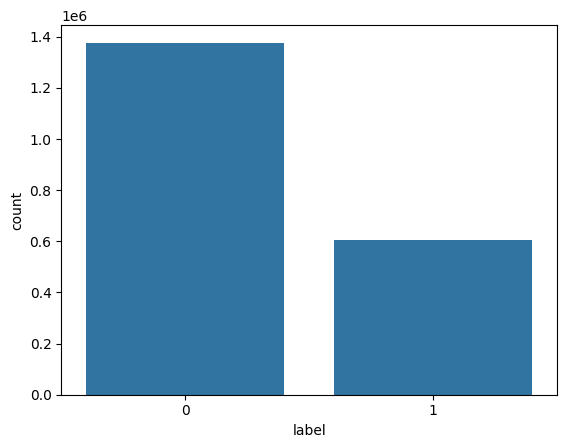

------------------------------------------------------------------------------------------------------------------------

Dataset: sentiment



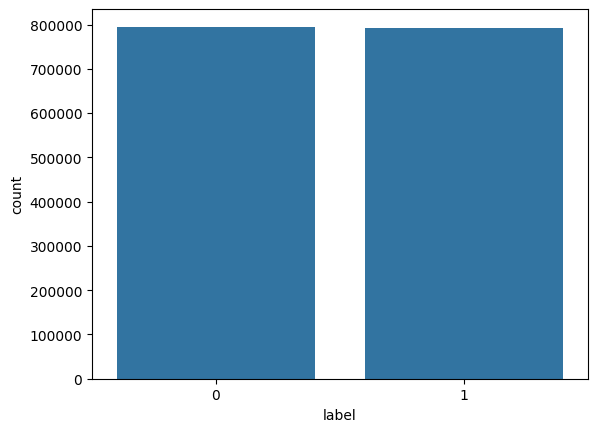

------------------------------------------------------------------------------------------------------------------------

Dataset: hate_speech



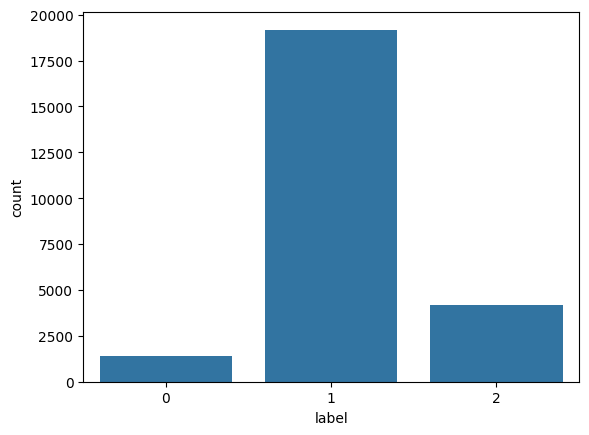

------------------------------------------------------------------------------------------------------------------------

Dataset: personality



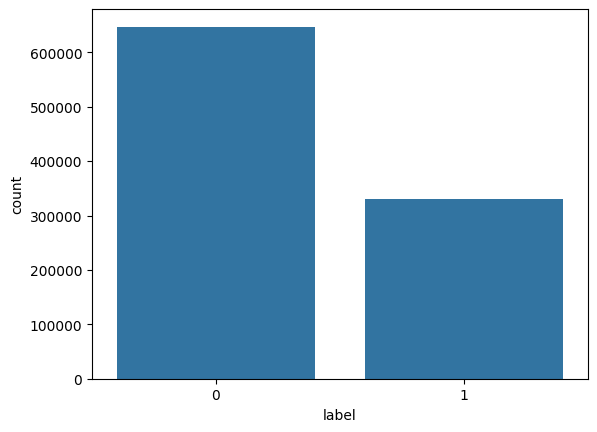

------------------------------------------------------------------------------------------------------------------------

Dataset: emotions



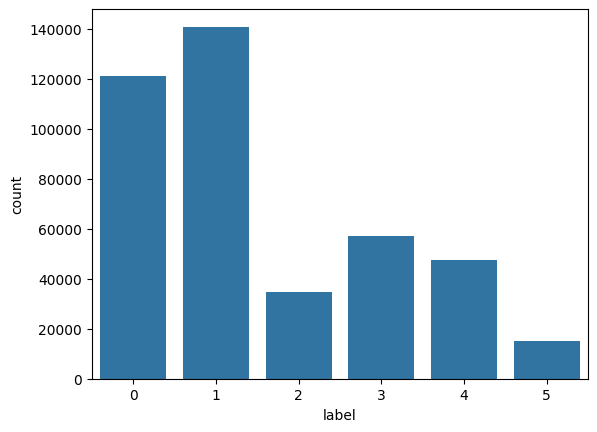

------------------------------------------------------------------------------------------------------------------------



In [ ]:
for dataset in dataframe_names:
  print(f'Dataset: {dataset}\n')
  sns.barplot(globals()[dataset]['label'].value_counts())
  plt.show()
  print('---'*40 + '\n')

In [ ]:
for dataset in dataframe_names:
  for value in globals()[dataset]['label'].unique():
    print(f'Dataset: {dataset} - Label: {value}\n')
    temp_dataset = globals()[dataset][(globals()[dataset]['label'] == value)]
    if dataset == 'personality':
      bag = ' '.join(temp_dataset['light_clean_text'].tolist())
    else:
      bag = ' '.join(temp_dataset['text'].tolist())
    wordcloud = WordCloud(stopwords = STOPWORDS).generate(bag)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    print('---'*40 + '\n')

Output hidden; open in https://colab.research.google.com to view.

# Predictions

In [34]:
clf_results_dict = {}

## Hate Speech

In [ ]:
## hate_speech ##

#         Vectorizer Features     Preprocessing  Accuracy Score  Duration (s)
# 0  CountVectorizer      All        Clean Text             1.0           0.6
# 0  CountVectorizer      All  light_clean_text             1.0           0.8
# 0  TfidfVectorizer      All        Clean Text             1.0           1.3

#            Classifier Vectorizer Features Preprocessing  Best Score     Duration (m)
# 0  LogisticRegression   FastText      All    Clean Text         1.0             0.01
# 0  LogisticRegression   FastText      All      Raw Text         1.0             0.01
# 0  LogisticRegression   FastText      All    Clean Text         1.0             0.01

# (max_df=0.5, max_features=1000, ngram_range=(1, 2))

In [ ]:
hate_vectorizer = CountVectorizer(max_df=0.5, max_features=1000, ngram_range=(1, 2))
hate_speech_clf = LogisticRegression()

recorder = Memory_recorder()
recorder.compile_recorder()

In [ ]:
data = hate_speech

preproc = 'clean_text'
features = 'All'

y = data['label']
x = data.drop(columns = ['text', 'light_clean_text', 'clean_text', 'label'])
x = pd.concat([x, data[preproc]], axis = 1)

x, y = x_encoder_y(x, y, features)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = 0.75)

X_train_features = X_train.drop(columns = preproc)
X_train_temp = X_train[preproc]
X_test_features = X_test.drop(columns = preproc)
X_test_temp = X_test[preproc]

start = timer_start()
recorder.start_recording()

hate_vectorizer.fit(X_train_temp)
X_train_vec = sp.sparse.hstack((hate_vectorizer.transform(X_train_temp), X_train_features.values.astype('float64')), format = 'csr')
X_test_vec = sp.sparse.hstack((hate_vectorizer.transform(X_test_temp), X_test_features.values.astype('float64')), format = 'csr')

hate_speech_clf.fit(X_train_vec, y_train)
pred = hate_speech_clf.predict(X_test_vec)

duration = timer_stop(start)
record = recorder.get_recording()

results = []
results.append(np.round(accuracy_score(y_test, pred), 4))
results.append(np.round(f1_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(recall_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(precision_score(y_test, pred, average = 'weighted', zero_division = 0), 4))

In [ ]:
clf_results_dict[1] = {
    'Dataset' : 'hate_speech',
    'Preprocessing': preproc,
    'Features': features,
    'Vectorizer': 'CountVectorizer',
    'Classifier': 'LogisticRegression',
    'Duration (s)': np.round(duration, 1),
    'Peak Memory (GB)': record,
    'Accuracy Score': results[0],
    'F1 Score': results[1],
    'Precision Score': results[3],
    'Recall Score': results[2]
    }

In [ ]:
results

[1.0, 1.0, 1.0, 1.0]

## Emotions

In [ ]:
## emotions ##

#         Vectorizer   Features     Preprocessing  Accuracy Score  Duration (s)
# 0  TfidfVectorizer  Text Only  light_clean_text          0.7687          18.8
# 0  TfidfVectorizer  Text Only          Raw Text          0.7642          18.8
# 0  CountVectorizer  Text Only  light_clean_text          0.7637          25.6

#                    Classifier       Vectorizer   Features Preprocessing    Best Score  Duration (m)
# 0  GradientBoostingClassifier  TfidfVectorizer        All      Raw Text        0.7175          1.48
# 0  GradientBoostingClassifier  CountVectorizer  Text Only      Raw Text        0.7120          0.91
# 0  GradientBoostingClassifier  TfidfVectorizer  Text Only      Raw Text        0.7110          1.48

# (max_df=0.25, max_features=10000, ngram_range=(1, 2), norm=None)

In [ ]:
emotions_vectorizer = TfidfVectorizer(max_df=0.25, max_features=10000, ngram_range=(1, 2), norm=None)
emotions_clf = GradientBoostingClassifier()

recorder = Memory_recorder()
recorder.compile_recorder()

In [ ]:
data = emotions

preproc = 'light_clean_text'
features = 'Text Only'

y = data['label']
x = data[preproc]

x, y = x_encoder_y(x, y, features)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = 50000/x.shape[0], test_size = 50000/x.shape[0])

start = timer_start()
recorder.start_recording()

emotions_vectorizer.fit(X_train)
X_train_vec = emotions_vectorizer.transform(X_train)
X_test_vec = emotions_vectorizer.transform(X_test)

emotions_clf.fit(X_train_vec, y_train)
pred = emotions_clf.predict(X_test_vec)

duration = timer_stop(start)
record = recorder.get_recording()

results = []
results.append(np.round(accuracy_score(y_test, pred), 4))
results.append(np.round(f1_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(recall_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(precision_score(y_test, pred, average = 'weighted', zero_division = 0), 4))

In [ ]:
clf_results_dict[2] = {
    'Dataset' : 'Emotions',
    'Preprocessing': preproc,
    'Features': features,
    'Vectorizer': 'TfidfVectorizer',
    'Classifier': 'GradientBoostingClassifier',
    'Duration (s)': np.round(duration, 1),
    'Peak Memory (GB)': record,
    'Accuracy Score': results[0],
    'F1 Score': results[1],
    'Precision Score': results[3],
    'Recall Score': results[2]
    }

In [ ]:
results

[0.8474, 0.8478, 0.8474, 0.8651]

## Personality

In [ ]:
## personality ##

#         Vectorizer Features     Preprocessing  Accuracy Score  Duration (s)
# 0  CountVectorizer      All  light_clean_text             1.0          14.3
# 0  CountVectorizer      All        Clean Text             1.0          14.4
# 0  CountVectorizer      All        Clean Text             1.0          14.5

#   Classifier Vectorizer Features Preprocessing  Best Score  Duration (m)
# 0        SVC   FastText      All    Clean Text         1.0          0.01
# 0        SVC   FastText      All      Raw Text         1.0          0.01
# 0        SVC   FastText      All    Clean Text         1.0          0.01

# (max_df=0.5, max_features=1000, ngram_range=(2, 2))

In [ ]:
personality_vectorizer = CountVectorizer(max_df=0.5, max_features=1000, ngram_range=(1, 2))
personality_clf = SVC()

recorder = Memory_recorder()
recorder.compile_recorder()

In [ ]:
data = personality

preproc = 'light_clean_text'
features = 'All'

y = data['label']
x = data.drop(columns = ['text', 'light_clean_text', 'clean_text', 'label'])
x = pd.concat([x, data[preproc]], axis = 1)

x, y = x_encoder_y(x, y, features)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = 50000/x.shape[0], test_size = 50000/x.shape[0])

X_train_features = X_train.drop(columns = preproc)
X_train_temp = X_train[preproc]
X_test_features = X_test.drop(columns = preproc)
X_test_temp = X_test[preproc]

start = timer_start()
recorder.start_recording()

personality_vectorizer.fit(X_train_temp)
X_train_vec = sp.sparse.hstack((personality_vectorizer.transform(X_train_temp), X_train_features.values.astype('float64')), format = 'csr')
X_test_vec = sp.sparse.hstack((personality_vectorizer.transform(X_test_temp), X_test_features.values.astype('float64')), format = 'csr')

personality_clf.fit(X_train_vec, y_train)
pred = personality_clf.predict(X_test_vec)

duration = timer_stop(start)
record = recorder.get_recording()

results = []
results.append(np.round(accuracy_score(y_test, pred), 4))
results.append(np.round(f1_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(recall_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(precision_score(y_test, pred, average = 'weighted', zero_division = 0), 4))

In [ ]:
clf_results_dict[3] = {
    'Dataset' : 'personality',
    'Preprocessing': preproc,
    'Features': features,
    'Vectorizer': 'CountVectorizer',
    'Classifier': 'SVC',
    'Duration (s)': np.round(duration, 1),
    'Peak Memory (GB)': record,
    'Accuracy Score': results[0],
    'F1 Score': results[1],
    'Precision Score': results[3],
    'Recall Score': results[2]
    }

In [ ]:
results

[0.9999, 0.9999, 0.9999, 0.9999]

## Botting

In [35]:
## botting ##

#         Vectorizer   Features Preprocessing  Accuracy Score  Duration (s)
# 0  TfidfVectorizer  Text Only      Raw Text          0.7338          31.1
# 0  CountVectorizer  Text Only      Raw Text          0.7335          22.2
# 0  CountVectorizer  Text Only      Raw Text          0.7329          25.8

#            Classifier       Vectorizer   Features Preprocessing  Best Score     Duration (m)
# 0  LogisticRegression  TfidfVectorizer  Text Only      Raw Text      0.7325             0.03
# 0  LogisticRegression  TfidfVectorizer  Text Only      Raw Text      0.7304             0.04
# 0                 SVC  TfidfVectorizer  Text Only      Raw Text      0.7300             0.02

# (max_df=0.25, ngram_range=(1, 3), norm=None)

In [36]:
botting_vectorizer = TfidfVectorizer(max_df=0.25, ngram_range=(1, 3), norm=None)
botting_clf = LogisticRegression()

recorder = Memory_recorder()
recorder.compile_recorder()

In [37]:
data = botting

preproc = 'text'
features = 'Text Only'

y = data['label']
x = data[preproc]

x, y = x_encoder_y(x, y, features)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = 50000/x.shape[0], test_size = 300000/x.shape[0])

start = timer_start()
recorder.start_recording()

botting_vectorizer.fit(X_train)
X_train_vec = botting_vectorizer.transform(X_train)
X_test_vec = botting_vectorizer.transform(X_test)

botting_clf.fit(X_train_vec, y_train)
pred = botting_clf.predict(X_test_vec)

duration = timer_stop(start)
record = recorder.get_recording()

results = []
results.append(np.round(accuracy_score(y_test, pred), 4))
results.append(np.round(f1_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(recall_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(precision_score(y_test, pred, average = 'weighted', zero_division = 0), 4))

In [38]:
clf_results_dict[4] = {
    'Dataset' : 'botting',
    'Preprocessing': preproc,
    'Features': features,
    'Vectorizer': 'TfidfVectorizer',
    'Classifier': 'LogisticRegression',
    'Duration (s)': np.round(duration, 1),
    'Peak Memory (GB)': record,
    'Accuracy Score': results[0],
    'F1 Score': results[1],
    'Precision Score': results[3],
    'Recall Score': results[2]
    }

In [39]:
results

[0.7829, 0.7746, 0.7829, 0.7744]

## Sentiment

In [ ]:
## sentiment ##

#         Vectorizer   Features Preprocessing  Accuracy Score  Duration (s)
# 0  TfidfVectorizer  Text Only      Raw Text          0.7015         461.9
# 0  CountVectorizer  Text Only      Raw Text          0.7013          28.1
# 0  TfidfVectorizer  Text Only      Raw Text          0.6871          30.2

#            Classifier       Vectorizer   Features Preprocessing  Best Score     Duration (m)
# 0  LogisticRegression  TfidfVectorizer  Text Only      Raw Text       0.688             0.02
# 0                 SVC  TfidfVectorizer  Text Only      Raw Text       0.688             0.02
# 0  LogisticRegression  TfidfVectorizer  Text Only      Raw Text       0.682             0.03

# (max_df=0.25, max_features=5000, ngram_range=(1, 2))

In [ ]:
sentiment_vectorizer = TfidfVectorizer(max_df=0.25, max_features=5000, ngram_range=(1, 2))
sentiment_clf = LogisticRegression()

recorder = Memory_recorder()
recorder.compile_recorder()

In [ ]:
data = sentiment

preproc = 'text'
features = 'Text Only'

y = data['label']
x = data[preproc]

x, y = x_encoder_y(x, y, features)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = 0.75)

start = timer_start()
recorder.start_recording()

sentiment_vectorizer.fit(X_train)
X_train_vec = sentiment_vectorizer.transform(X_train)
X_test_vec = sentiment_vectorizer.transform(X_test)

sentiment_clf.fit(X_train_vec, y_train)
pred = sentiment_clf.predict(X_test_vec)

duration = timer_stop(start)
record = recorder.get_recording()

results = []
results.append(np.round(accuracy_score(y_test, pred), 4))
results.append(np.round(f1_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(recall_score(y_test, pred, average = 'weighted'), 4))
results.append(np.round(precision_score(y_test, pred, average = 'weighted', zero_division = 0), 4))

In [ ]:
clf_results_dict[5] = {
    'Dataset' : 'sentiment',
    'Preprocessing': preproc,
    'Features': features,
    'Vectorizer': 'TfidfVectorizer',
    'Classifier': 'LogisticRegression',
    'Duration (s)': np.round(duration, 1),
    'Peak Memory (GB)': record,
    'Accuracy Score': results[0],
    'F1 Score': results[1],
    'Precision Score': results[3],
    'Recall Score': results[2]
    }

In [ ]:
results

[0.7955, 0.7955, 0.7955, 0.7957]

# Results

## Classification Results

In [ ]:
clf_results = pd.DataFrame([])
for i in clf_results_dict.keys():
  clf_results = pd.concat([clf_results, pd.json_normalize(clf_results_dict[i])])

In [ ]:
clf_results

,Dataset,Preprocessing,Features,Vectorizer,Classifier,Duration (s),Peak Memory (GB),Accuracy Score,F1 Score,Precision Score,Recall Score
0,hate_speech,clean_text,All,CountVectorizer,LogisticRegression,1.8,8.24,1.0000,1.0000,1.0000,1.0000
0,Emotions,light_clean_text,Text Only,TfidfVectorizer,GradientBoostingClassifier,61.0,8.41,0.8474,0.8478,0.8651,0.8474
0,personality,light_clean_text,All,CountVectorizer,SVC,27.6,8.95,0.9999,0.9999,0.9999,0.9999
0,botting,text,Text Only,TfidfVectorizer,LogisticRegression,24.7,10.15,0.7845,0.7757,0.7760,0.7845
0,sentiment,text,Text Only,TfidfVectorizer,LogisticRegression,99.8,11.63,0.7955,0.7955,0.7957,0.7955


## XAI - Sample

### Botting

In [ ]:
data = botting

preproc = 'text'
features = 'Text Only'

y = data['label']
x = data[preproc]

x, y = x_encoder_y(x, y, features)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = 5000/x.shape[0], test_size = 100/x.shape[0])

vectorizer = TfidfVectorizer(min_df = 10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model = RandomForestClassifier(n_estimators = 10)
model.fit(X_train_vec, y_train)

feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)

Text: unmasking   probe   commission   barr   concludes   charge   public   report   october   non   surprise - Label 0


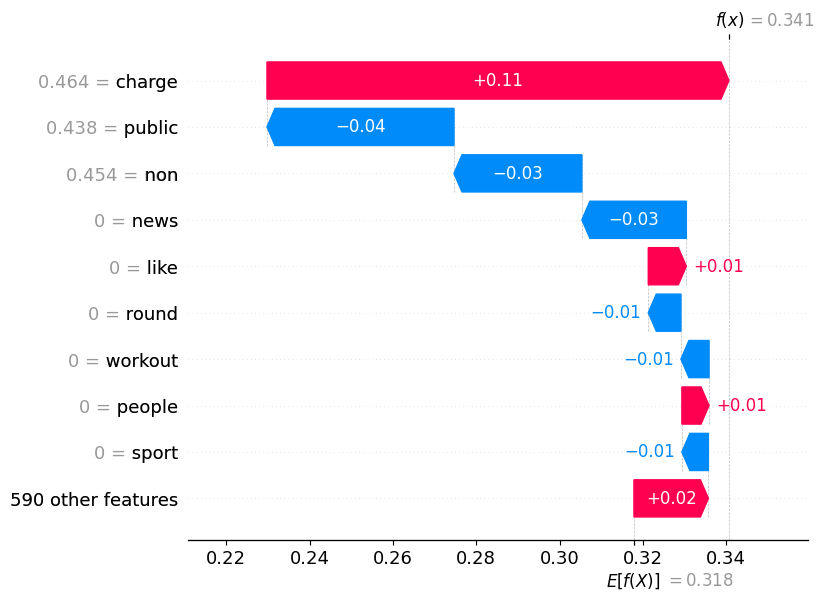

In [ ]:
print(f'Text: {X_test.iloc[6]} - Label {y_test[6]}')
shap.initjs()
shap.plots.waterfall(shap_values[6,:,1])

Text: playing   genius   motherfu   feat   chip   gt - Label: 1


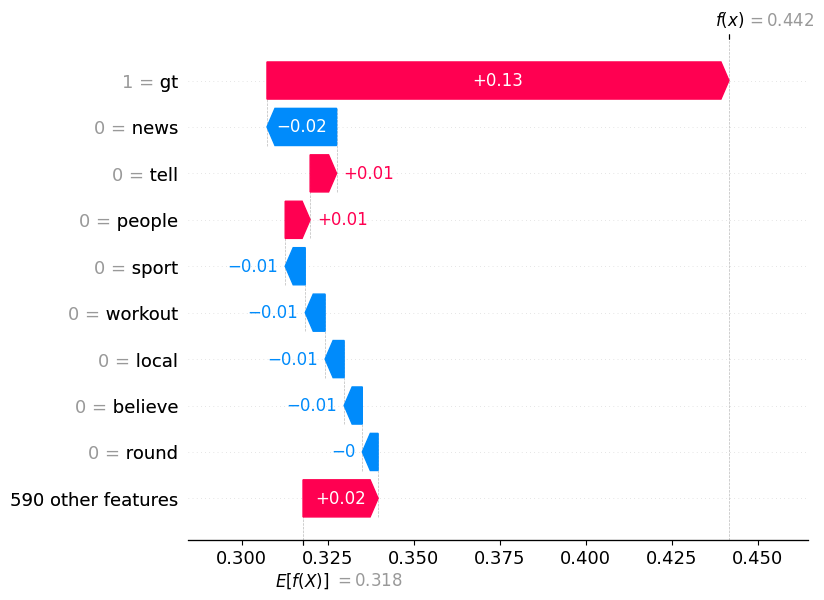

In [ ]:
print(f'Text: {X_test.iloc[1]} - Label: {y_test[1]}')
shap.initjs()
shap.plots.waterfall(shap_values[1,:,1])

### Personality

In [ ]:
data = personality

preproc = 'light_clean_text'
features = 'Text Only'

y = data['label']
x = data[preproc]

x, y = x_encoder_y(x, y, features)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = 5000/x.shape[0], test_size = 100/x.shape[0])

vectorizer = TfidfVectorizer(min_df = 10)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

model = RandomForestClassifier(n_estimators = 10)
model.fit(X_train_vec, y_train)

feature_names = vectorizer.get_feature_names_out()
explainer = shap.Explainer(model, X_train_vec, feature_names=feature_names)
shap_values = explainer(X_test_vec)

Text:  who thought they were straight from the start lets be real  - Label 0


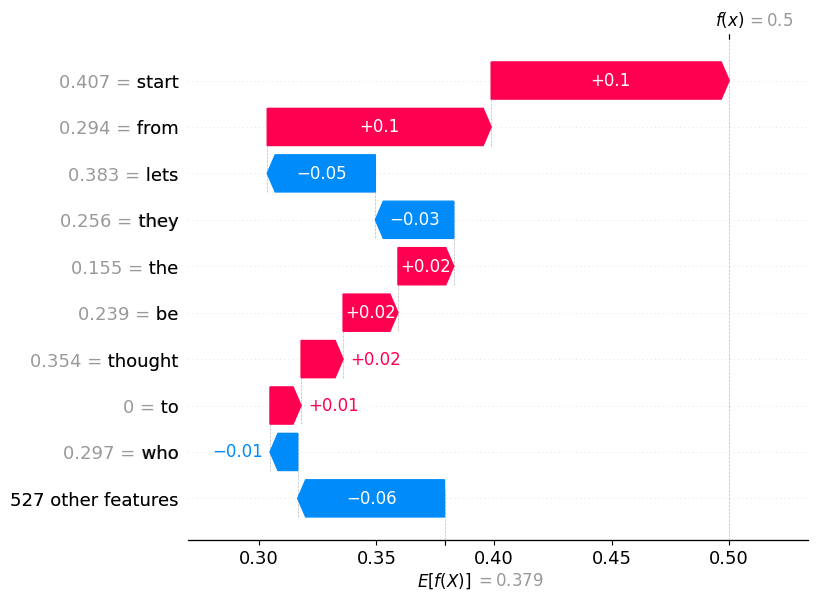

In [ ]:
print(f'Text: {X_test.iloc[6]} - Label {y_test[6]}')
shap.initjs()
shap.plots.waterfall(shap_values[6,:,1])

Text:   i am going to kiss u both - Label: 1


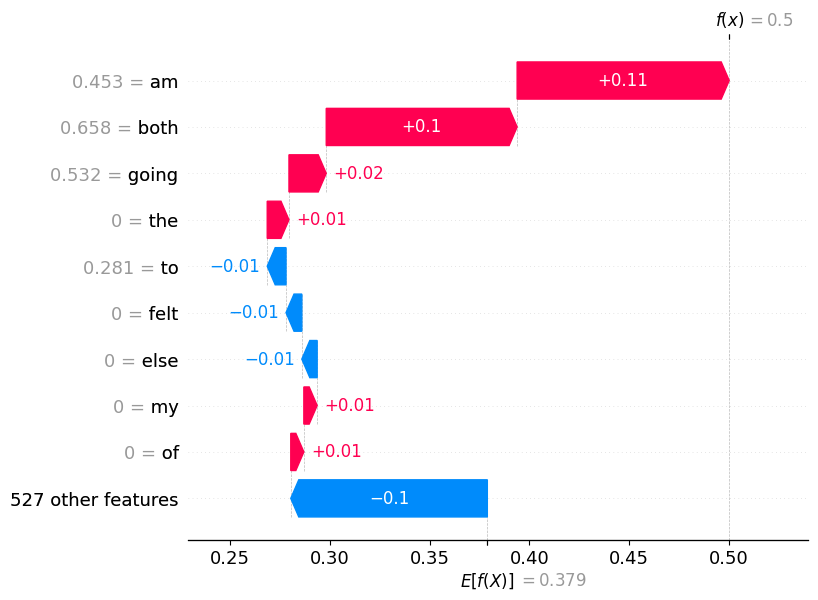

In [ ]:
print(f'Text: {X_test.iloc[2]} - Label: {y_test[2]}')
shap.initjs()
shap.plots.waterfall(shap_values[2,:,1])

# Applying Models

In [5]:
auth.authenticate_user()

project_id = 'nlp-project-427710'
client = bigquery.Client(project = project_id)

datasets_names = list(client.list_datasets())
project = client.project
dataframe_names = []

for dataset in datasets_names:
  dataset_name = client.get_dataset(dataset.dataset_id)
  tables_names = list(client.list_tables(dataset_name))
  for table in tables_names:
    if table.table_id == 'uns_prep_covid1' or table.table_id == 'uns_ukraine_war1':
      query = f"""
      SELECT *
      FROM {project_id}.{dataset.dataset_id}.{table.table_id}
      """
      df = client.query(query).to_dataframe()
      dataframe_names.append(table.table_id)
      globals()[table.table_id] = globals().pop('df')

In [6]:
dataframe_names

['uns_prep_covid1', 'uns_ukraine_war1']

In [7]:
uns_prep_covid1.columns

Index(['status_id', 'text', 'upper_words', 'tweet_length', 'no_sentences',
       'has_username', 'has_hashtag', 'ELIPSIS_instances', 'light_clean_text',
       'clean_text'],
      dtype='object')

In [8]:
uns_ukraine_war1.columns

Index(['Unnamed: 0', 'userid', 'username', 'location', 'following',
       'followers', 'totaltweets', 'tweetid', 'retweetcount', 'text',
       'language', 'favorite_count'],
      dtype='object')

In [40]:
data = uns_ukraine_war1

preproc = 'text'

x = data[preproc]

X_vec = botting_vectorizer.transform(x)
pred_ukr = botting_clf.predict(X_vec)

<Axes: ylabel='count'>

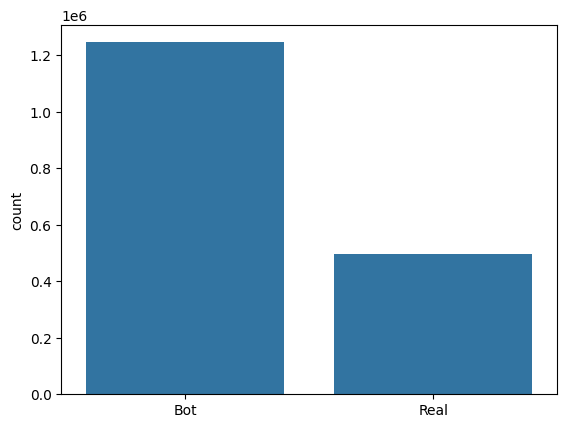

In [41]:
keys = []
for i in pred_ukr:
  if i == 1:
    keys.append('Bot')
  else:
    keys.append('Real')
sns.countplot(x = keys)

In [46]:
data = uns_prep_covid1

preproc = 'text'

x = data[preproc]

X_vec = botting_vectorizer.transform(x)
pred_covid = botting_clf.predict(X_vec)

<Axes: ylabel='count'>

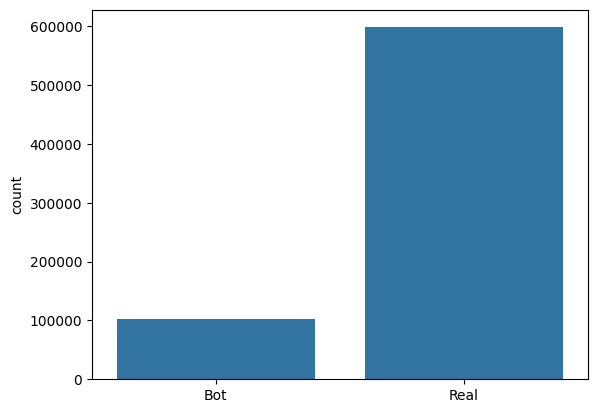

In [47]:
keys = []
for i in pred_covid:
  if i == 1:
    keys.append('Bot')
  else:
    keys.append('Real')
sns.countplot(x = keys)

In [48]:
data = uns_prep_covid1

preproc = 'light_clean_text'

x = data[preproc]

X_vec = botting_vectorizer.transform(x)
pred_covid = botting_clf.predict(X_vec)

<Axes: ylabel='count'>

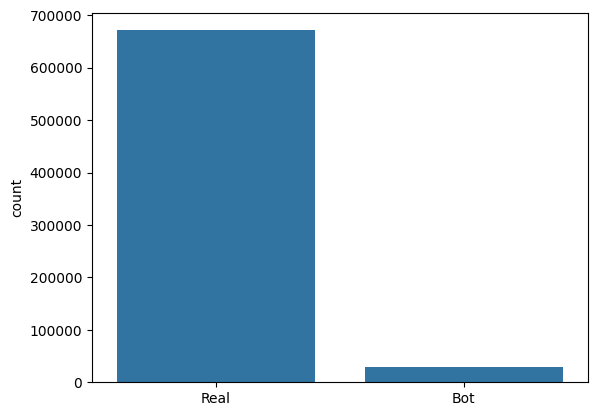

In [49]:
keys = []
for i in pred_covid:
  if i == 1:
    keys.append('Bot')
  else:
    keys.append('Real')
sns.countplot(x = keys)